# Sentiment Analysis Using IMDB

First, install the required packages

In [5]:
!pip install transformers datasets hf_xet accelerate>=0.26.0 tf-keras

If you get an auth error on tf-keras, use <b>!pip install tf-keras --user

# Before Continuing, restart your kernel for the package installs to take effect

In [6]:
# import required packages
# this cell is complete
import warnings
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import DataCollatorWithPadding
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

Ignore user and depreciation warnings

In [9]:
# this cell is complete
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

Load the IMDB dataset

In [11]:
dataset = load_dataset("imdb")

Use a subset for training and testing - use a seed of 42, training range of 1000 and testing range of 200

In [13]:
train_dataset = dataset['train'].shuffle(seed=42).select(range(1000))
test_dataset = dataset['test'].shuffle(seed=42).select(range(200))

Display basic information about the datasets

In [17]:
# this cell is complete
print("Train dataset size:", len(train_dataset))
print("Test dataset size:", len(test_dataset))
print("\n" + "-"*50 + "\n")

Train dataset size: 1000
Test dataset size: 200

--------------------------------------------------



Display the column names/features

In [15]:
# this cell is complete
print("Dataset features:", train_dataset.column_names)
print("\n" + "-"*50 + "\n")

Dataset features: ['text', 'label']

--------------------------------------------------



Display a few examples from the training set

In [19]:
# this cell is complete
print("Sample examples from training set:")
for i in range(3):  # Show first 3 examples
    print(f"\nExample {i+1}:")
    example = train_dataset[i]
    
    # Print text (truncated if too long)
    text = example['text']
    if len(text) > 200:
        text = text[:200] + "... (truncated)"
    print(f"Text: {text}")
    
    # Print label
    label_id = example['label']
    label_name = "Positive" if label_id == 1 else "Negative"
    print(f"Label: {label_name} ({label_id})")
    print("\n" + "-"*50 + "\n")

Sample examples from training set:

Example 1:
Text: There is no relation at all between Fortier and Profiler but the fact that both are police series about violent crimes. Profiler looks crispy, Fortier looks classic. Profiler plots are quite simple. F... (truncated)
Label: Positive (1)

--------------------------------------------------


Example 2:
Text: This movie is a great. The plot is very true to the book which is a classic written by Mark Twain. The movie starts of with a scene where Hank sings a song with a bunch of kids called "when you stub y... (truncated)
Label: Positive (1)

--------------------------------------------------


Example 3:
Text: George P. Cosmatos' "Rambo: First Blood Part II" is pure wish-fulfillment. The United States clearly didn't win the war in Vietnam. They caused damage to this country beyond the imaginable and this mo... (truncated)
Label: Negative (0)

--------------------------------------------------



Check label distribution

In [29]:
train_labels = [example['label'] for example in train_dataset]
test_labels = [example['label'] for example in test_dataset]

train_positive = sum(train_labels)
train_negative = len(train_labels) - train_positive
test_positive = sum(test_labels)
test_negative = len(test_labels) - test_positive

print("Label distribution:")
print(f"Training set: {train_positive} positive, {train_negative} negative")
print(f"Test set: {test_positive} positive, {test_negative} negative")
print("\n" + "-"*50 + "\n")

Label distribution:
Training set: 488 positive, 512 negative
Test set: 96 positive, 104 negative

--------------------------------------------------



<b>Load a pre-trained tokenizer</b>

Using the matching pre-trained tokenizer is crucial because:
- If you used a different tokenizer, the model wouldn't understand the input, as it expects specific token IDs that correspond to its vocabulary.
- The model was trained with text processed in a specific way, so using the same tokenizer ensures consistency.

When you call `from_pretrained()`, the tokenizer is downloaded from the Hugging Face Hub, including its vocabulary file and configuration, ensuring perfect compatibility with the model you're using.

In [86]:
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [33]:
print(tokenizer.tokenize("Just testing it out"))

['just', 'testing', 'it', 'out']


<b>Tokenize the datasets</b> <br><br>
The tokenizer processes the "text" field of each example, applying transformations. The `batched=True` parameter allows for efficient processing of multiple examples at once.
<br>
The resulting `tokenized_train_dataset` contains the original fields plus new ones like `input_ids` (token IDs), `attention_mask`, and potentially `token_type_ids` depending on the model

In [88]:
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True)

tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

<b>Load a pre-trained model</b> - see information at the end of this example to understand selecting pretrained models. <br>
In this example with `AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)`, I'm taking advantage of a model that already understands language patterns and adapting it specifically for a binary classification task.

In [43]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<i>You may receive information in a pink output cell. This warning is informational and not an error. 
It's telling you that when you loaded the pre-trained DistilBERT model and added a classification head (for your specific task), some layers were initialized with random weights because they weren't part of the original pre-trained model.

This is expected behavior when you're adapting a pre-trained model for a specific downstream task like text classification. The warning is just reminding you that you should train the model before using it for predictions.</i>

<br><b>Define data collator</b><br><br>
The data collator is initialized with your tokenizer so it knows:
- What padding token to use
- What the model's vocabulary is
- What the maximum sequence length should be

Later, when you pass this to the `Trainer` class, it uses this collator during training to dynamically create optimized batches. This is more efficient than pre-padding the entire dataset because:
1. It minimizes the amount of padding used
2. It reduces memory usage
3. It speeds up training by avoiding unnecessary computations on padding tokens

Without a data collator, you would need to manually handle all these batch preparation steps.

In [49]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Define evaluation metrics

In [79]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

Set up training arguments

In [81]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",  
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

Initialize Trainer

In [71]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

<b>Train the model - this step may take up to 40 minutes to execute.</b>

In [73]:
# this cell is complete
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.347800,0.612735,0.850000,0.835165,0.883721,0.791667
2,0.048400,0.731399,0.855000,0.859903,0.801802,0.927083


TrainOutput(global_step=250, training_loss=0.17420496182143688, metrics={'train_runtime': 2361.1011, 'train_samples_per_second': 0.847, 'train_steps_per_second': 0.106, 'total_flos': 248428117557600.0, 'train_loss': 0.17420496182143688, 'epoch': 2.0})

<b>A low training loss suggests the model is fitting well to the training data</b><br>
For a more detailed explaination of the trainer output, I have added information to the end of this Notebook.

Evaluate the model

In [75]:
eval_results = trainer.evaluate()
print(f"Evaluation results: {eval_results}")

Evaluation results: {'eval_loss': 0.7313987612724304, 'eval_accuracy': 0.855, 'eval_f1': 0.8599033816425121, 'eval_precision': 0.8018018018018018, 'eval_recall': 0.9270833333333334, 'eval_runtime': 30.4323, 'eval_samples_per_second': 6.572, 'eval_steps_per_second': 0.821, 'epoch': 2.0}


Visualize results

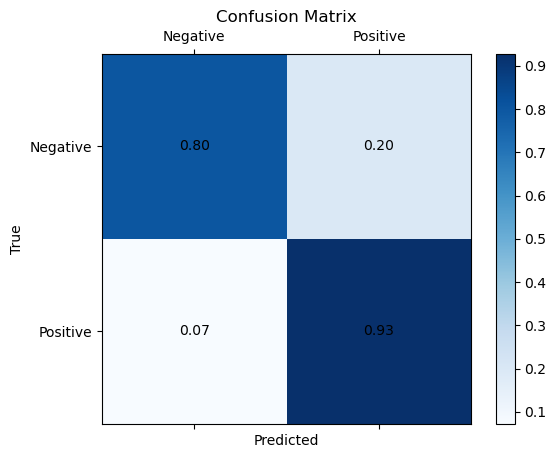

In [77]:
# this cell is complete
labels = ["Negative", "Positive"]
conf_matrix = np.array([[eval_results['eval_precision'], 1 - eval_results['eval_precision']],
                        [1 - eval_results['eval_recall'], eval_results['eval_recall']]])

fig, ax = plt.subplots()
cax = ax.matshow(conf_matrix, cmap='Blues')
fig.colorbar(cax)

for (i, j), val in np.ndenumerate(conf_matrix):
    ax.text(j, i, f'{val:.2f}', ha='center', va='center', color='black')

ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

**********************

Choosing the right pre-trained model depends on several factors. Here's how you can make an informed decision:

1. **Task requirements**: 
   - For text classification: BERT, RoBERTa, DistilBERT, XLNet
   - For sequence generation: T5, BART, GPT-2
   - For token classification (NER): BERT, RoBERTa
   - For question answering: BERT, RoBERTa, ALBERT

2. **Resource constraints**:
   - Limited resources: DistilBERT, MobileBERT, TinyBERT
   - More resources available: RoBERTa, BERT-large, XLNet

3. **Language requirements**:
   - English only: Most models with "base" or "english" in name
   - Multilingual: models with "multilingual" in name
   - Specific languages: language-specific models (e.g., CamemBERT for French)

4. **Performance vs. speed tradeoff**:
   - Faster inference: DistilBERT, ALBERT
   - Higher accuracy: RoBERTa, XLNet

5. **Domain specificity**:
   - General text: BERT, RoBERTa
   - Scientific/biomedical: BioBERT, SciBERT
   - Code: CodeBERT

You can explore models on the Hugging Face Hub (https://huggingface.co/models) and filter by task, language, etc.

For your specific example with binary classification (`num_labels=2`), models like DistilBERT, BERT, or RoBERTa with `AutoModelForSequenceClassification` are good choices.

*****************************

# Understanding TrainOutput in Hugging Face Transformers

This output is from a Hugging Face Transformers model training session. Let me break down what each component means:

## Training Metrics Explained

- **global_step=250**: The total number of training steps (batches) processed during training.

- **training_loss=0.3090102338790894**: The average loss across all training steps. This relatively low value (0.309) suggests the model is learning well.

- **train_runtime: 21166.7664**: Total training time in seconds (about 5.9 hours).

- **train_samples_per_second: 0.094**: The model processed approximately 0.094 samples per second, indicating a relatively slow training speed.

- **train_steps_per_second: 0.012**: The model completed about 0.012 training steps per second.

- **total_flos: 248428117557600.0**: Total floating-point operations performed during training (approximately 248.4 trillion FLOPs), indicating computational complexity.

- **epoch: 2.0**: The model completed exactly 2 epochs of training.

## Interpretation

This output shows a model that:
- Trained for 2 complete epochs
- Achieved a good loss value of 0.309
- Required significant computational resources (248.4T FLOPs)
- Had relatively slow processing speed (0.094 samples/second)